In [1]:
# Unconditioned

In [2]:
# %pip install -q diffusers

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as transforms

from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 加载数据

In [2]:
# 检查一个图片格式
img_path = "Dfinetune/test/HF_Sava_000468a_20220614_60x.x_9438.y_38379.png"
# 打开图片
img = Image.open(img_path)
print("分辨率:", img.size)  # (宽, 高)
print("色彩:", img.mode)   # RGB or L(灰度)

分辨率: (186, 126)
色彩: L


In [3]:
class DiatomDataset(Dataset):
    def __init__(self, split_csv, label_csv, root_dir, transform=None):
        """
        Args:
            split_csv (str): train.csv/test.csv 路径
            label_csv (str): label.csv 路径
            root_dir (str): 图片所在文件夹路径 (train/ 或 test/)
            transform (callable, optional): 图像转换pipeline
        """
        # 加载文件名列表
        self.file_list = pd.read_csv(split_csv, header=None, names=['filename'])
        
        # 加载标签映射
        label_df = pd.read_csv(label_csv, sep=",", header=None, names=["filename", "label"])
        self.label_map = dict(zip(label_df.filename, label_df.label))
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 获取文件名和标签
        img_name = self.file_list.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        # 加载图像
        image = Image.open(img_path)
        # 类型转换(暂时不需要)
        # image = Image.open(img_path).convert("L")  # 彩色图.convert("RGB")
        
        # 查找标签
        if img_name not in self.label_map:
            raise ValueError(f"找不到标签: {img_name} 在 labels.csv")
        label = int(self.label_map[img_name])
        
        # 预处理
        if self.transform:
            image = self.transform(image)
        elif self.transform1:
            image = self.transform1(image)
        elif self.transform2:
            image = self.transform2(image)
        return image, label


In [4]:
# 图像处理pipeline
# 1.简单缩放
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # rgb
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2.padding
transform1 = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Pad(padding=(0, (128 - img.size[1]) // 2)),  # 高度补齐
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3.裁剪缩放
transform2 = transforms.Compose([
    transforms.Lambda(lambda img: transforms.CenterCrop(min(img.size))(img)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 路径变量
train_csv = "Dfinetune/train.csv"
test_csv  = "Dfinetune/test.csv"
label_csv = "Dfinetune/labels.csv"
train_root = "Dfinetune/train"
test_root  = "Dfinetune/test"

# 数据集和加载器
train_set = DiatomDataset(train_csv, label_csv, train_root, transform=transform2)
test_set  = DiatomDataset(test_csv,  label_csv, test_root,  transform=transform2)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False)


Batch shape: torch.Size([8, 1, 64, 64])
Labels: tensor([30, 26,  0, 21,  3,  0, 14,  2])


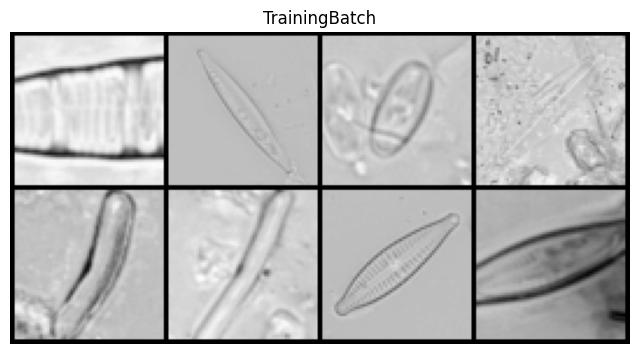

In [5]:
# 获取一个 batch, 验证加载
x, y = next(iter(train_loader))
print("Batch shape:", x.shape)
print("Labels:", y)

# 可视化
grid_img = torchvision.utils.make_grid(x, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("TrainingBatch")
plt.axis('off')
plt.show()

## 1. Create Class-Conditioned UNet2D


In [22]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

## 2. 训练

In [33]:
# 线性噪声调度
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

Finished epoch 0. Average loss for this epoch: 0.019088
Finished epoch 1. Average loss for this epoch: 0.011925
Finished epoch 2. Average loss for this epoch: 0.010913


(0.0, 0.1)

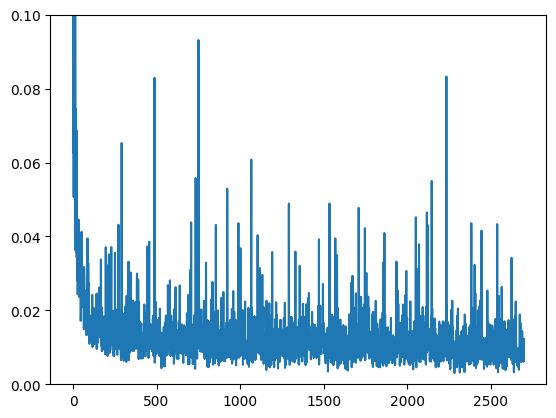

In [24]:
# Dataloader (you can mess with batch size)
batch_size = 128

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_loader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_loader) :]) / len(train_loader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

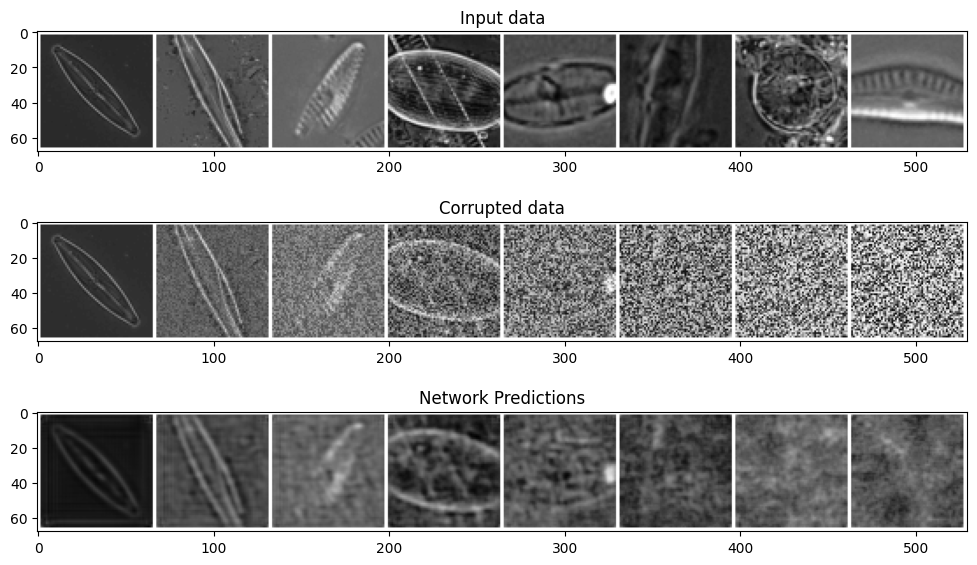

In [26]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_loader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

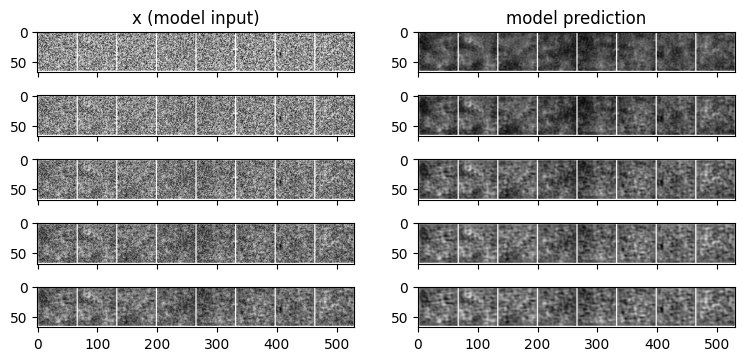

In [30]:
# 改变训练目标为预测噪声
noise = ... # 随机噪声
noisy_x = corrupt(x, amount)
pred = net(noisy_x)
loss = loss_fn(pred, noise)  # 预测噪声而非干净图像